# Parallel parameter space exploration

Parameter space explorations (PSE) are a common tool for understanding the effect of parameters on a model's dynamics. This notebook shows you how to get started with parameter space explorations in TVB, running the simulations in parallel on your machines multicore processor.

## Goals

- Configure a template simulation
- Analyze a feature of simulated time series
- Set up a parameter space to explore
- Run parallel simulations on all available cores of your workstation
- Visualize results of parameter space exploration
- Adapt parameter space and rerun previous steps

## Prelude

The following cell imports all the libraries required for this notebook and should be executed once before getting started.

In [1]:
import itertools
import multiprocessing
from tvb.simulator.lab import *
from time import time
%pylab inline
import matplotlib as mpl
mpl.rcParams['image.interpolation'] = 'none'

## Configuring a template simulation

The first task is configuring a template simulation which serves as the basis for the parameter sweep. This depends on your modeling question, but as an example, we will examine the effect of noise and coupling strength on correlation between structural and functional connectivity.

First, we'll define a function that takes specific values of our parameters and runs a typical simulation with them:

In [2]:
def run_sim(cs, D, cv=3.0, dt=0.1, simlen=1e3):
    sim = simulator.Simulator(
        model=models.Generic2dOscillator(a=0.0),
        connectivity=connectivity.Connectivity(load_default=True, speed=cv),
        coupling=coupling.Linear(a=cs),
        integrator=integrators.HeunStochastic(dt=dt, noise=noise.Additive(nsig=array([D]))),
        monitors=monitors.TemporalAverage(period=1.0) # 200 Hz
    )
    sim.configure()
    (t, y), = sim.run(simulation_length=simlen)
    return t, y[:, 0, :, 0]

Next, we'll look results of this simulation for specific parameter values. It's useful to execute the following cell multiple times with different values to judge their effect and useful ranges:

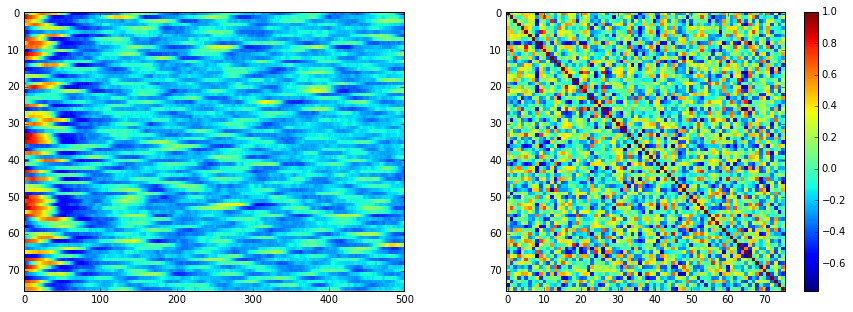

In [3]:
t, y = run_sim(0.01, 2e-3, simlen=500.0)

# create mask for samples after transient
t_mask = t > 150.0

# compute functional connectivity
FC = corrcoef(y[t_mask].T)

figure(figsize=(15, 5))
subplot(1, 2, 1), imshow(y.T, aspect='auto')
subplot(1, 2, 2), imshow(FC), colorbar();

## Feature of simulated time series

And course, the correlation with the structural connectivity,

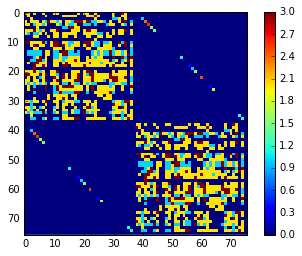

In [34]:
imshow(connectivity.Connectivity(load_default=True).weights)
colorbar();

which is the feature we're looking for:

In [4]:
SC = connectivity.Connectivity(load_default=True).weights
corrcoef(FC.ravel(), SC.ravel())[0, 1]

0.086276753343333859

Wrapping it all up (parameters to FC-SC value) into a single function, we have:

In [5]:
def fc_sc_for_params(args):
    cs, D = args
    t, y = run_sim(cs, D, simlen=500.0)
    t_mask = t > 150.0
    FC = corrcoef(y[t_mask].T)
    return corrcoef(FC.ravel(), SC.ravel())[0, 1]

# example
fc_sc_for_params((0.01, 0.002))

0.086276753343333859

## Exploring the parameter space

Now that we have a feature (SC-FC correlation) defined as a function of our parameter space, we can apply it to different values of our parameters to obtain a map of the parameter space.

### A computational aside

However, running all these simulations can take some time. TVB's simulator is currently single-threaded which means it only uses one core at a time. If you have a recent computer, you likely have at least two cores for a laptop or at least four or more for a recent workstation.

This means you can run multiple simulations at the same time and get results back more quickly. The following shows a simple recipe for doing this.

In [6]:
# lists of all parameters' values
cs =  10**r_[-2.5 : -1.0 : 50j]
D =  10**r_[-5.0 : -1.0 : 50j]

# make list of all combinations of parameter values (one per simulation)
param_combos = list(itertools.product(cs, D))

'%d simulations to run' % (len(param_combos), )

'2500 simulations to run'

Now we run all simulations using all cores of the machine:

In [7]:
pool = multiprocessing.Pool()
tic = time()
results = pool.map(fc_sc_for_params, param_combos)
toc = time() - tic
pool.close()
toc

1189.1089279651642

2500 simulations on a 8-core workstation took around 20 minutes.

## Visualizing the results


This `results` isn't quite what we need because it's a flat list, where we did a 2D parameter sweep, so let's reshape it according to the dimensions of our parameter sweep:

In [8]:
fcsc = array(results).reshape((len(cs), len(D)))

Now, visualize contours of the FC-SC correlation as a function of coupling strength and noise

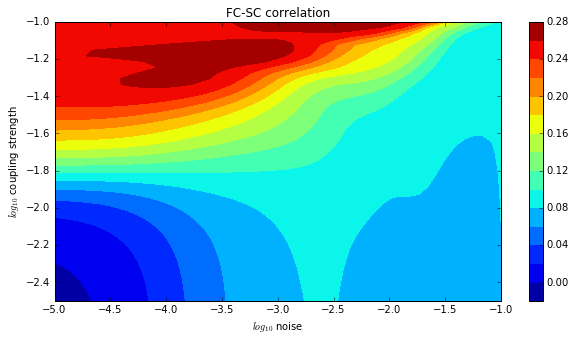

In [9]:
X, Y = log10(meshgrid(D, cs))
figure(figsize=(10, 5))
contourf(X, Y, fcsc, 15)
xlabel('$log_{10}$ noise')
ylabel('$log_{10}$ coupling strength')
title('FC-SC correlation')
colorbar();

We now have a basic parameter space of SC-FC correlation as a function of noise and coupling strength.

What do the time series and correlation matrix look like for the maximum correlation value?

In [10]:
imax = argmax(fcsc)
cs_max = cs[imax / len(cs)]
D_max = D[imax % len(cs)]
(cs_max, D_max)

(0.070297321153254724, 0.00042919342601287783)

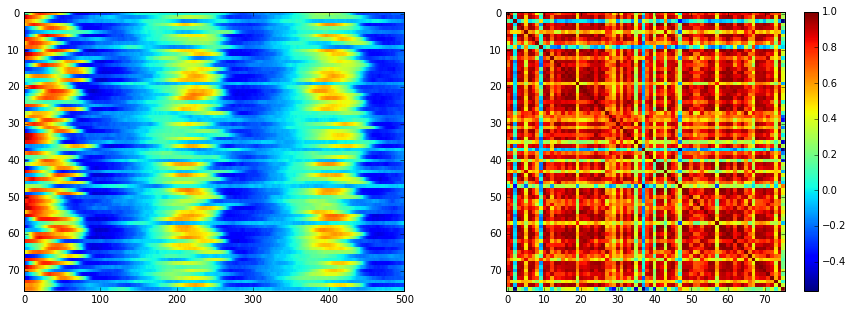

In [11]:
t, y = run_sim(cs_max, D_max, simlen=500.0)
t_mask = t > 150.0
FC = corrcoef(y[t_mask].T)
figure(figsize=(15, 5))
subplot(1, 2, 1), imshow(y.T, aspect='auto')
subplot(1, 2, 2), imshow(FC), colorbar();

## A second parameter space

The parameter space above shows the interplay between coupling strength and noise, but these are hardly the only highly influential parameters in the model. 

Another interesting parameter to explore is the conduction speed, and to do that we can reuse quite a bit of the above code, just changing what parameters are used for simulation (and using the `D_max` found above as the noise level):

In [20]:
def fc_sc_for_params2(args):
    cs, cv = args
    t, y = run_sim(cs, D_max, cv=cv, simlen=3000.0)
    t_mask = t > 150.0
    FC = corrcoef(y[t_mask].T)
    return corrcoef(FC.ravel(), SC.ravel())[0, 1]

Here again, defining the parameter values

In [21]:
cv = r_[1.0 : 10.0 : 50j]

# make list of all combinations of parameter values (one per simulation)
param_combos2 = list(itertools.product(cs, cv))

'%d simulations to run' % (len(param_combos), )

'2500 simulations to run'

and then running all simulations

In [22]:
pool = multiprocessing.Pool()
tic = time()
results = pool.map(fc_sc_for_params2, param_combos2)
toc = time() - tic
pool.close()
toc

6459.957566976547

and visualizing the results

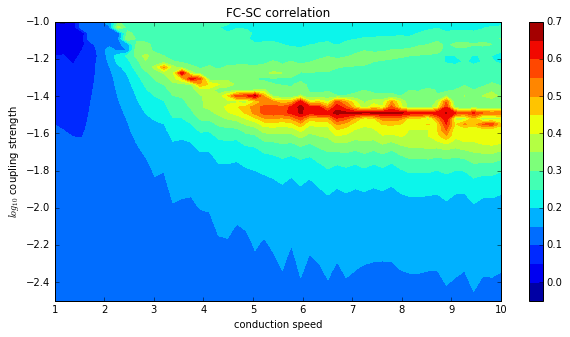

In [24]:
fcsc2 = array(results).reshape((len(cs), len(cv)))
X2, Y2 = meshgrid(cv, cs)
figure(figsize=(10, 5))
contourf(X2, log10(Y2), fcsc2, 15)
xlabel('conduction speed')
ylabel('$log_{10}$ coupling strength')
title('FC-SC correlation')
colorbar();

Again, we can look at the best coupling strength and speed values,

In [28]:
imax = argmax(fcsc2)
cs_max = cs[imax / len(cs)]
cv_max = cv[imax % len(cs)]
(cs_max, cv_max)

(0.032374575428176434, 6.6938775510204085)

And their time series

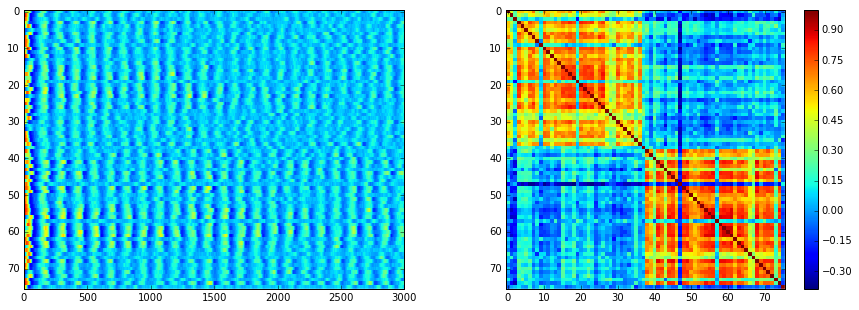

In [29]:
t, y = run_sim(cs_max, D_max, cv=cv_max, simlen=3000.0)
t_mask = t > 150.0
FC = corrcoef(y[t_mask].T)
figure(figsize=(15, 5))
subplot(1, 2, 1), imshow(y.T, aspect='auto')
subplot(1, 2, 2), imshow(FC), colorbar();

Here we can see that the best FC-SC correlation

In [31]:
fcsc2.max()

0.66452569100250425

corresponds to a conduction speed (`6.69`) different from the default (`3.0`).

It's also worthwhile to note that this second PSE used a longer simulation (3 s) than the first (500 ms).

## Conclusions

This notebook has demonstrated several techniques around exporing parameter space explorations.

In some cases, the parameters to explore are obvious, but other times it is necessary to try several combinations of parameters the right effect.

Finally, when the number of parameters to explore is too large, analysis and visualization become ineffective, and it's necessary to find a more specific modeling question.